In [251]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/milkquality/milknew.csv


In [252]:
df = pd.read_csv('/kaggle/input/milkquality/milknew.csv')

In [253]:
df.shape,df.dtypes,df.head()

((1059, 8),
 pH            float64
 Temprature      int64
 Taste           int64
 Odor            int64
 Fat             int64
 Turbidity       int64
 Colour          int64
 Grade          object
 dtype: object,
     pH  Temprature  Taste  Odor  Fat   Turbidity  Colour   Grade
 0  6.6          35      1     0     1          0     254    high
 1  6.6          36      0     1     0          1     253    high
 2  8.5          70      1     1     1          1     246     low
 3  9.5          34      1     1     0          1     255     low
 4  6.6          37      0     0     0          0     255  medium)

In [254]:
df.isnull().sum()

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [256]:
df.nunique()

pH            16
Temprature    17
Taste          2
Odor           2
Fat            2
Turbidity      2
Colour         9
Grade          3
dtype: int64

In [257]:
features = [i for i in df.columns]
features

['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour', 'Grade']

In [258]:
def show_countplot(df,feature,hue=None):
    plt.figure(figsize=(15,8))
    ax=sns.countplot(data=df,x=feature,hue=hue)
    ax.set_title(feature + '  Vs. ' + 'Target')
    for p in ax.patches:
        text = str(round(p.get_height()/len(df)*100,2))+'%'
        ax.text(p.get_x(),p.get_height(),text)
    plt.show()
    
def show_pieplot(df,feature):
    plt.figure(figsize=(15,8))
    counts = df[feature].value_counts()
    values = counts.values
    keys = counts.index
    color= sns.color_palette('dark')
    plt.pie(x=values,labels=keys,colors=color,autopct='%.0f%%')
    plt.title('Pie chart for '+feature)
    plt.show()

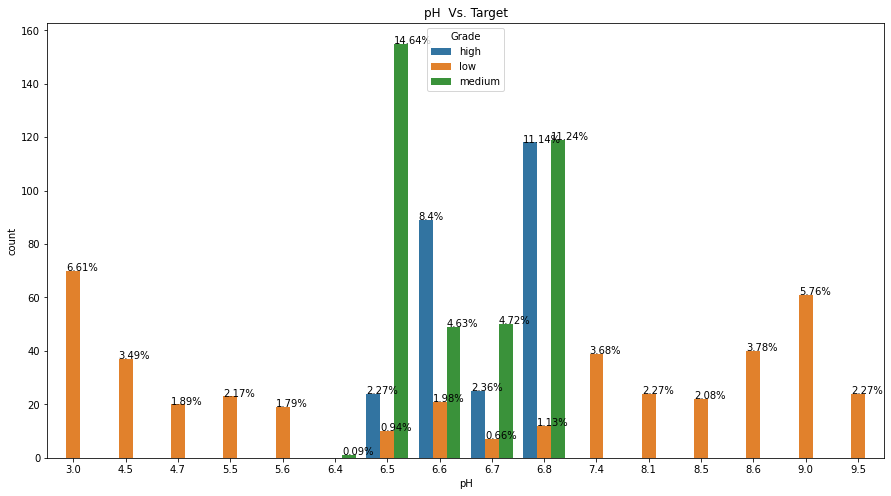

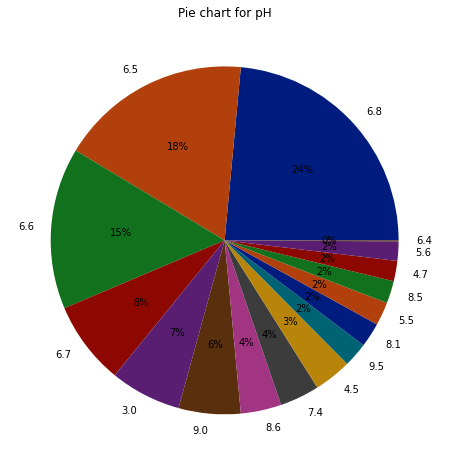

In [259]:
show_countplot(df,'pH',hue='Grade')
show_pieplot(df,'pH')

* Good Quality in pH range 6.4 to 6.8
* 6.5 ph shown highest HIGH quality & 6.4 being lowest


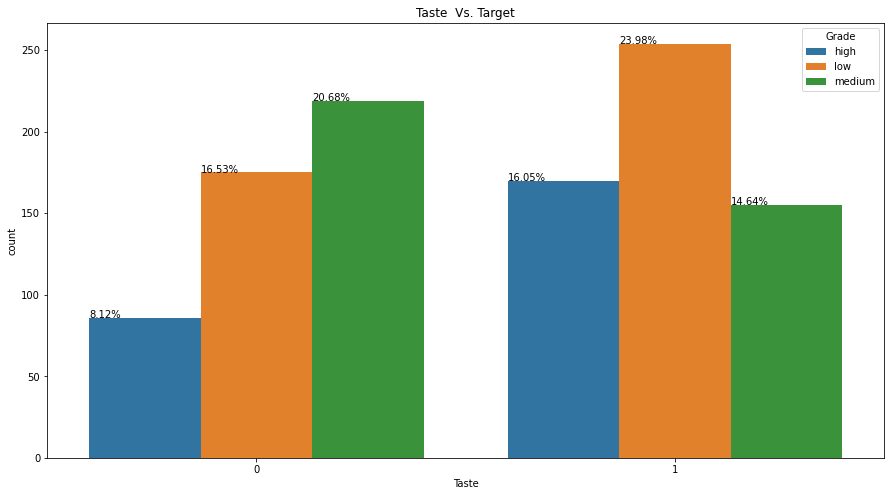

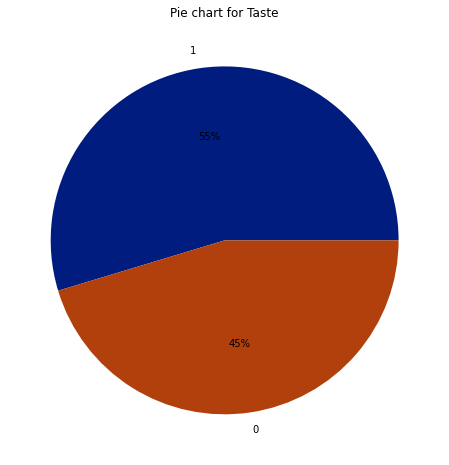

In [260]:
show_countplot(df,'Taste',hue='Grade')
show_pieplot(df,'Taste')

* Taste does not show any remarkable relation with Grade


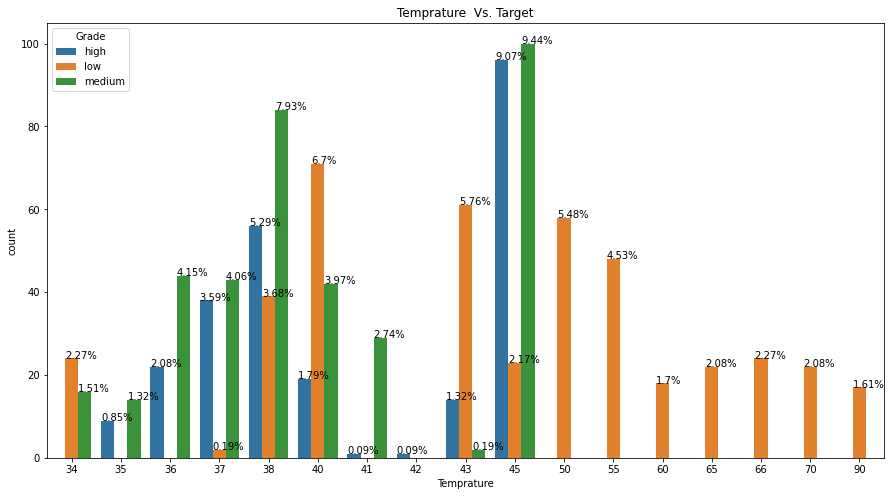

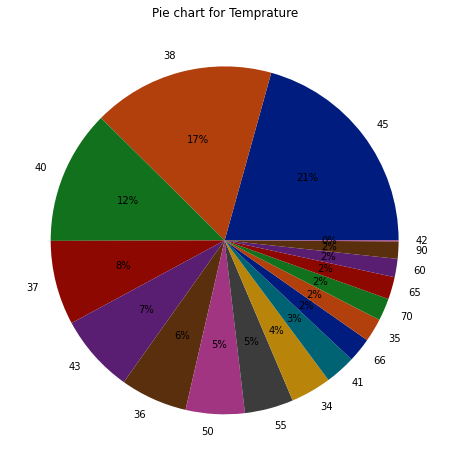

In [261]:

show_countplot(df,'Temprature',hue='Grade')
show_pieplot(df,'Temprature')

* Temperature at 45 have more data points and it is the optimal for the High grade milk
* Above 45 the Grade of milk is low

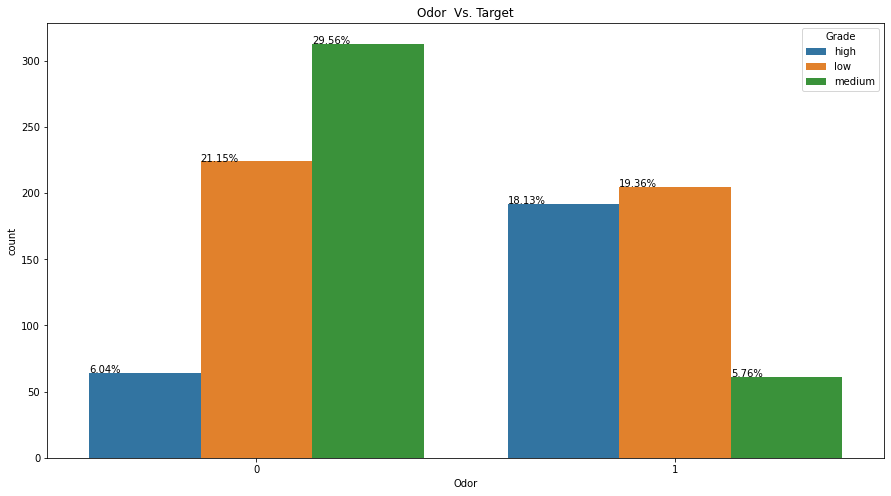

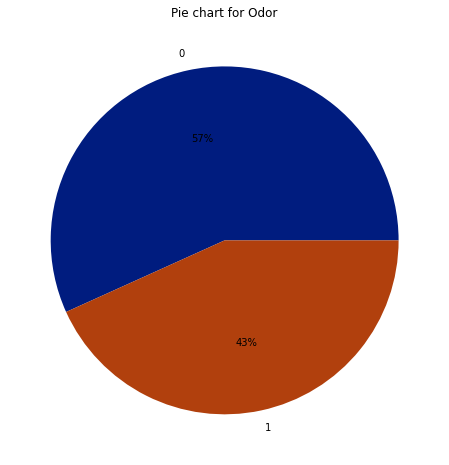

In [262]:
show_countplot(df,'Odor',hue='Grade')
show_pieplot(df,'Odor')

* With Odor in the milk, it is likely to be very good or very bad.
* Without Odor the milk Grade is medium

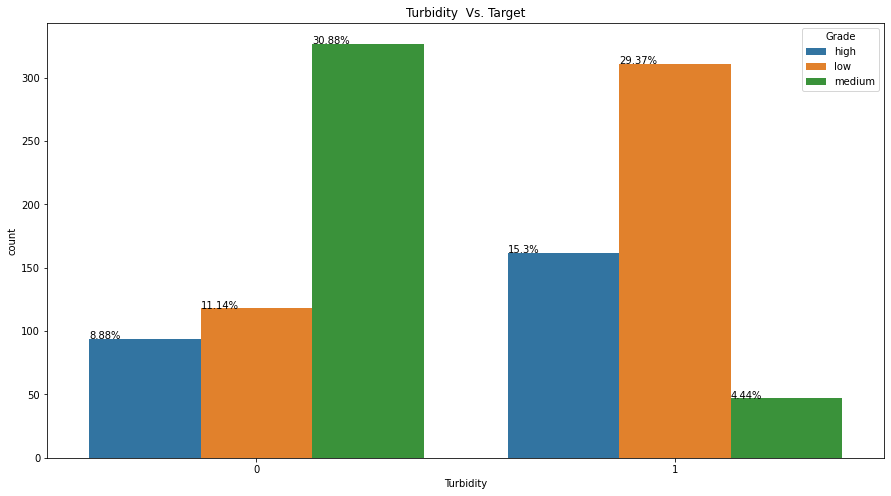

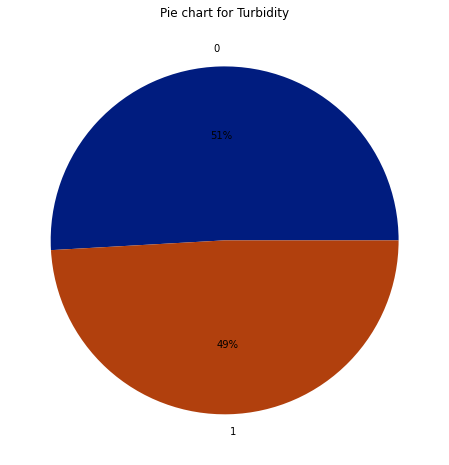

In [263]:
show_countplot(df,'Turbidity',hue='Grade')
show_pieplot(df,'Turbidity')

* No relation with respect to High Grade milk

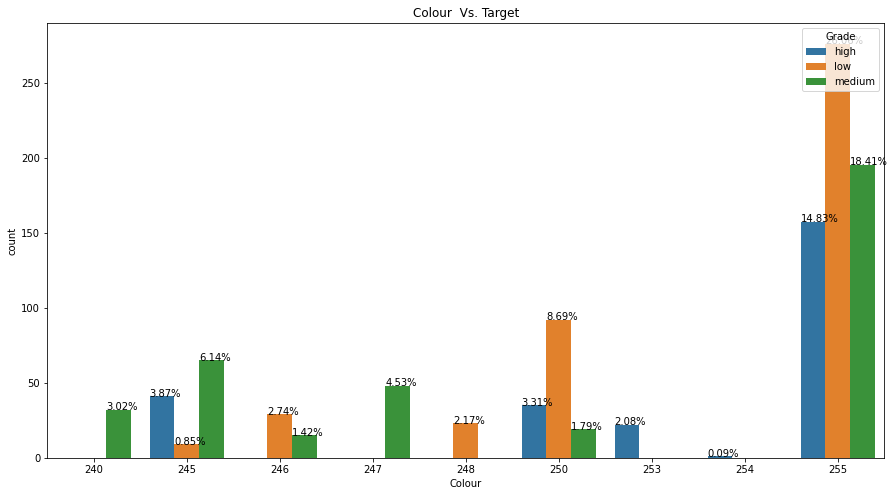

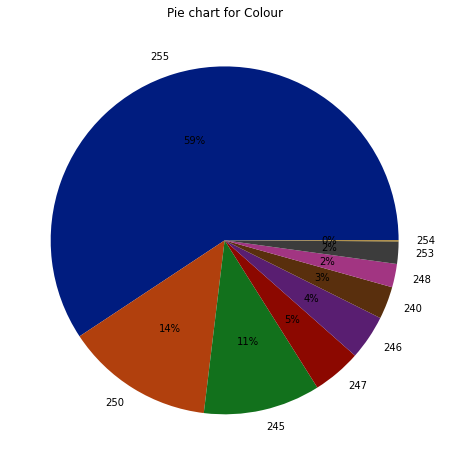

In [264]:
show_countplot(df,'Colour',hue='Grade')
show_pieplot(df,'Colour')

* No relation with color
* 255 shares most of the data points upto 59%

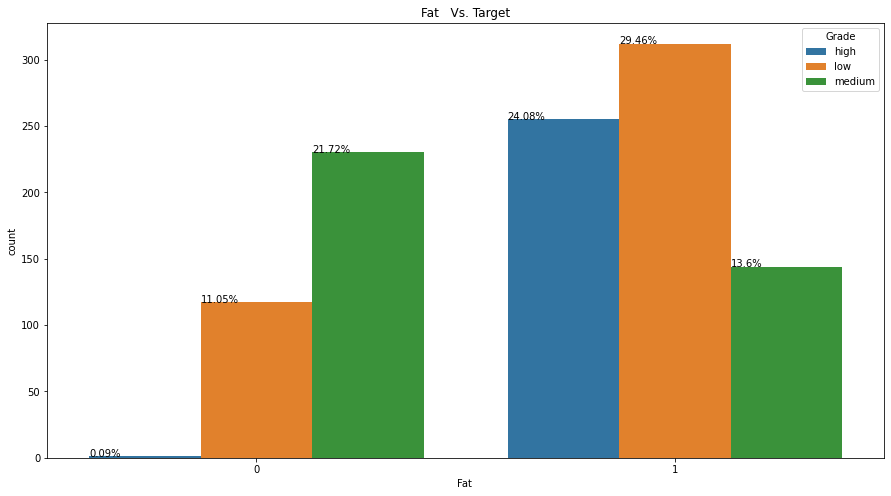

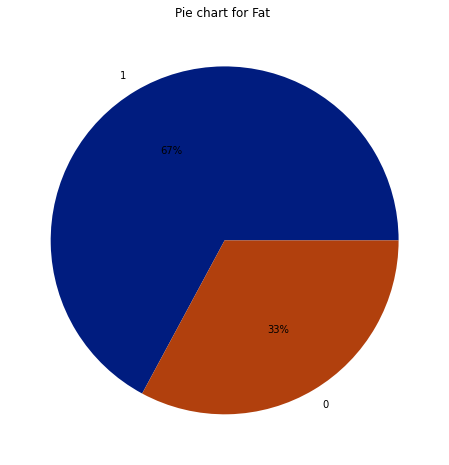

In [265]:
show_countplot(df,'Fat ',hue='Grade')
show_pieplot(df,'Fat ')

* Milk with no fat is most likely to be Low grade or Medium
* Milk with fat is most likely to be High grade

In [266]:
df.head(3)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low


In [267]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,LabelBinarizer
le = LabelEncoder()
target = le.fit_transform(df.Grade)
map_dict = dict(zip(target,df.Grade))

In [268]:
df.Grade = target

<AxesSubplot:>

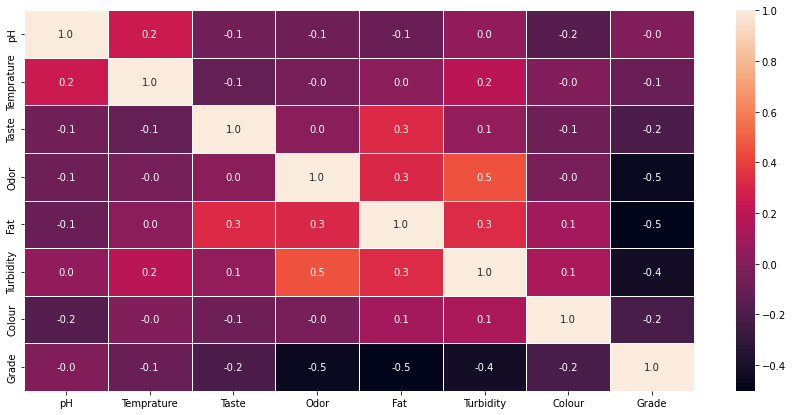

In [269]:
plt.figure(figsize=(15,7))
data = df.corr()
sns.heatmap(data,annot=True,fmt='.1f',linewidths=0.5)

* Odor,Fat,Turbudity,Colour & Taste Are important to Classify grade
* pH and Temperature show less covariance

In [270]:
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import confusion_matrix,accuracy_score

In [271]:
X = df.drop('Grade',1)
y = df.Grade
X = np.array(X)
y = np.array(y)

In [272]:
y

array([0, 0, 1, ..., 1, 0, 1])

In [273]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=28)

In [274]:
scaler = StandardScaler()

In [315]:
def KNN(x_train,y_train,x_test,y_test,scale=False,N=None,plot=True,show_knn_graph=False):
    optimal_k=N
    if N:
        print('"TO USE BEST K VALUE SET N=None"')
        model = KNeighborsClassifier(n_neighbors=N)
    else:
        score={}
        for k in range(1,30,2):
            model = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(model,x_train,y_train,cv=10,scoring='accuracy')
            score[scores.mean()]=k
        optimal_k=score.get(max(score.keys()))
        print('Best K value:',optimal_k)
        model = KNeighborsClassifier(n_neighbors=optimal_k)
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print('Model accuracy with k={} is : {}'.format(optimal_k,accuracy_score(y_test,pred)))
    cm = confusion_matrix(y_test,pred)
    
    if plot:
        plt.figure(figsize=(15,8))
        ax = sns.heatmap(cm,annot=True,linewidths=0.5,fmt=".1f")
        plt.show()
    else:
        print('Confusion matrix: \n',cm)
    if show_knn_graph:
        if N == None:
            xax=[]
            yax=[]
            for y,x in score.items():
                xax.append(x)
                yax.append(y)
            plt.plot(xax,yax)
            plt.title("Variation of Accuracy with K")
            plt.xlabel('K values')
            plt.ylabel('Accuracy')
            plt.grid()
        

Best K value: 3
Model accuracy with k=3 is : 0.9874213836477987


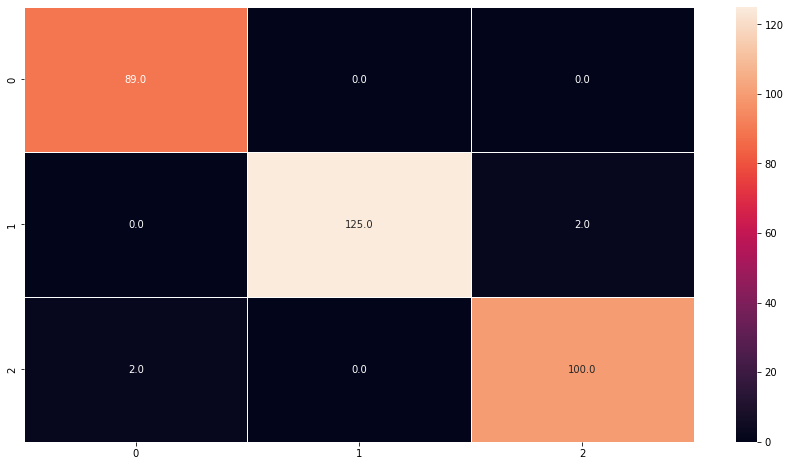

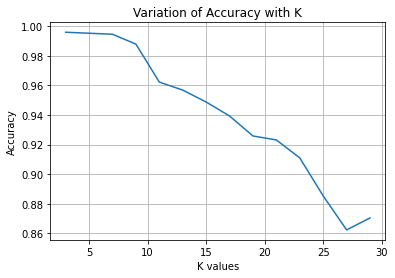

In [317]:
KNN(x_train,y_train,x_test,y_test,N=None,plot=True,show_knn_graph=True)

In [319]:
def RFC(x_train,y_train,x_test,y_test,plot=True):
    model = RandomForestClassifier()
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print('Model Accuracy = ',accuracy_score(y_test,pred))
    cm = confusion_matrix(y_test,pred)
    if plot:
        plt.figure(figsize=(15,8))
        ax = sns.heatmap(cm,annot=True,linewidths=0.5,fmt=".1f")
        plt.show()
    else:
        print('Confusion matrix: \n',cm)
        
    

Model Accuracy =  0.9937106918238994


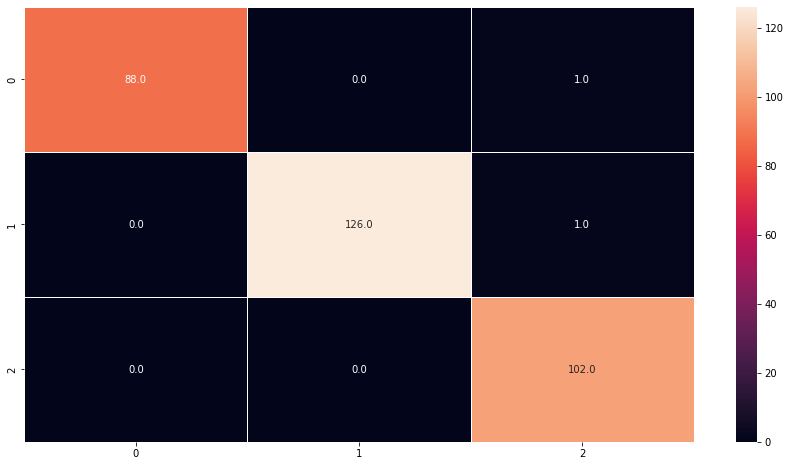

In [320]:
RFC(x_train,y_train,x_test,y_test)

In [321]:
def XGB(x_train,y_train,x_test,y_test,plot=True):
    model = XGBClassifier()
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print('Model Accuracy = ',accuracy_score(y_test,pred))
    cm = confusion_matrix(y_test,pred)
    if plot:
        plt.figure(figsize=(15,8))
        ax = sns.heatmap(cm,annot=True,linewidths=0.5,fmt=".1f")
        plt.show()
    else:
        print('Confusion matrix: \n',cm)

Model Accuracy =  0.9937106918238994


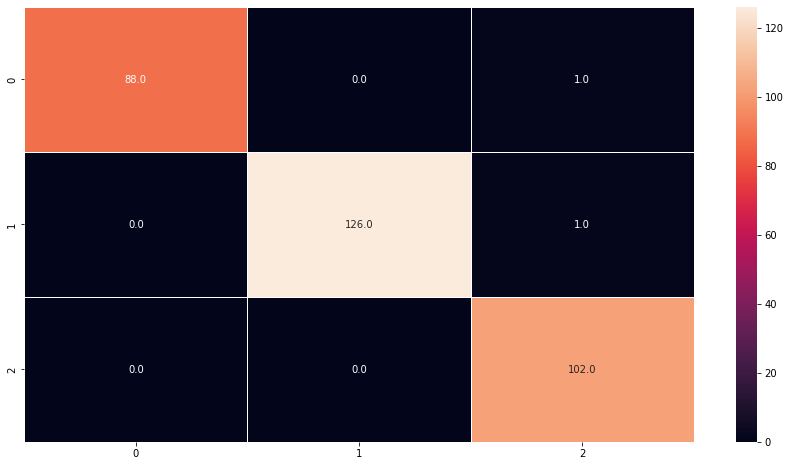

In [322]:
XGB(x_train,y_train,x_test,y_test)

In [323]:
def DT(x_train,y_train,x_test,y_test,plot=True):
    model = DecisionTreeClassifier()
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print('Model Accuracy = ',accuracy_score(y_test,pred))
    cm = confusion_matrix(y_test,pred)
    if plot:
        plt.figure(figsize=(15,8))
        ax = sns.heatmap(cm,annot=True,linewidths=0.5,fmt=".1f")
        plt.show()
    else:
        print('Confusion matrix: \n',cm)

Model Accuracy =  0.9905660377358491


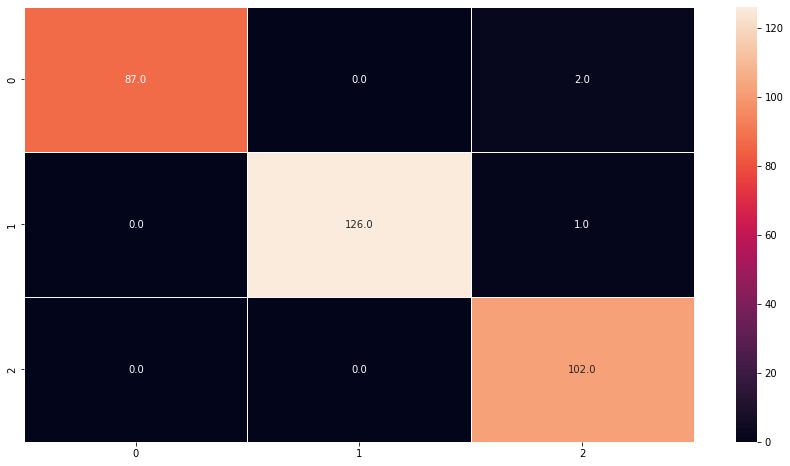

In [324]:
DT(x_train,y_train,x_test,y_test)

* CHECKING ACCURACY WITH SELECTED FEATURES FOR ALL MODELS

In [334]:
for i in range(2,8):
    x_new = SelectKBest(chi2,k=i).fit_transform(X,y)
    print('WITH {} SELECTED FEATURES\n'.format(i))
    x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.3)
    RFC(x_train,y_train,x_test,y_test,plot=False)

WITH 2 SELECTED FEATURES

Model Accuracy =  0.7515723270440252
Confusion matrix: 
 [[43 11 27]
 [12 99 13]
 [11  5 97]]
WITH 3 SELECTED FEATURES

Model Accuracy =  0.8364779874213837
Confusion matrix: 
 [[ 42  18  15]
 [  2 105  16]
 [  1   0 119]]
WITH 4 SELECTED FEATURES

Model Accuracy =  0.8427672955974843
Confusion matrix: 
 [[ 64  11  16]
 [ 10 100   4]
 [  7   2 104]]
WITH 5 SELECTED FEATURES

Model Accuracy =  0.9182389937106918
Confusion matrix: 
 [[ 59   9   4]
 [  8 114   0]
 [  4   1 119]]
WITH 6 SELECTED FEATURES

Model Accuracy =  0.9182389937106918
Confusion matrix: 
 [[ 55   7   4]
 [  7 126   0]
 [  8   0 111]]
WITH 7 SELECTED FEATURES

Model Accuracy =  0.9968553459119497
Confusion matrix: 
 [[ 67   0   0]
 [  1 133   0]
 [  0   0 117]]


In [338]:
for i in range(2,8):
    x_new = SelectKBest(chi2,k=i).fit_transform(X,y)
    print('WITH {} SELECTED FEATURES\n'.format(i))
    x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.3)
    XGB(x_train,y_train,x_test,y_test,plot=False)

WITH 2 SELECTED FEATURES

Model Accuracy =  0.7704402515723271
Confusion matrix: 
 [[ 38  11  26]
 [ 13 102  11]
 [  6   6 105]]
WITH 3 SELECTED FEATURES

Model Accuracy =  0.7861635220125787
Confusion matrix: 
 [[ 37  14  22]
 [  1 115  15]
 [  1  15  98]]
WITH 4 SELECTED FEATURES

Model Accuracy =  0.8773584905660378
Confusion matrix: 
 [[ 69  10   0]
 [ 11 113   0]
 [ 13   5  97]]
WITH 5 SELECTED FEATURES

Model Accuracy =  0.889937106918239
Confusion matrix: 
 [[ 62  10   0]
 [  6 126   0]
 [ 13   6  95]]
WITH 6 SELECTED FEATURES

Model Accuracy =  0.9182389937106918
Confusion matrix: 
 [[ 69   8   5]
 [  6 123   0]
 [  7   0 100]]
WITH 7 SELECTED FEATURES

Model Accuracy =  0.9968553459119497
Confusion matrix: 
 [[ 80   0   1]
 [  0 123   0]
 [  0   0 114]]


In [337]:
for i in range(2,8):
    x_new = SelectKBest(chi2,k=i).fit_transform(X,y)
    print('WITH {} SELECTED FEATURES\n'.format(i))
    x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.3)
    DT(x_train,y_train,x_test,y_test,plot=False)

WITH 2 SELECTED FEATURES

Model Accuracy =  0.7830188679245284
Confusion matrix: 
 [[ 42  11  25]
 [ 14  99  10]
 [  6   3 108]]
WITH 3 SELECTED FEATURES

Model Accuracy =  0.7924528301886793
Confusion matrix: 
 [[ 33  17  26]
 [  1 110  21]
 [  0   1 109]]
WITH 4 SELECTED FEATURES

Model Accuracy =  0.8836477987421384
Confusion matrix: 
 [[ 46  12   7]
 [ 11 133   0]
 [  6   1 102]]
WITH 5 SELECTED FEATURES

Model Accuracy =  0.9056603773584906
Confusion matrix: 
 [[ 52   9   7]
 [  6 130   0]
 [  7   1 106]]
WITH 6 SELECTED FEATURES

Model Accuracy =  0.9088050314465409
Confusion matrix: 
 [[ 67   8   4]
 [  7 114   0]
 [  9   1 108]]
WITH 7 SELECTED FEATURES

Model Accuracy =  0.9937106918238994
Confusion matrix: 
 [[ 82   0   0]
 [  2 127   0]
 [  0   0 107]]


In [333]:
for i in range(2,8):
    x_new = SelectKBest(chi2,k=i).fit_transform(X,y)
    print('WITH {} SELECTED FEATURES\n'.format(i))
    x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.3)
    KNN(x_train,y_train,x_test,y_test,plot=False)

WITH 2 SELECTED FEATURES

Best K value: 23
Model accuracy with k=23 is : 0.7327044025157232
Confusion matrix: 
 [[ 35  21  28]
 [  9 108  11]
 [ 11   5  90]]
WITH 3 SELECTED FEATURES

Best K value: 21
Model accuracy with k=21 is : 0.8238993710691824
Confusion matrix: 
 [[ 47  14  20]
 [  6 118  10]
 [  0   6  97]]
WITH 4 SELECTED FEATURES

Best K value: 11
Model accuracy with k=11 is : 0.8679245283018868
Confusion matrix: 
 [[ 74  10   8]
 [ 13  97   0]
 [  8   3 105]]
WITH 5 SELECTED FEATURES

Best K value: 3
Model accuracy with k=3 is : 0.8679245283018868
Confusion matrix: 
 [[ 65  22   1]
 [  1 118   4]
 [  7   7  93]]
WITH 6 SELECTED FEATURES

Best K value: 3
Model accuracy with k=3 is : 0.8710691823899371
Confusion matrix: 
 [[ 45  11  24]
 [  0 124   5]
 [  0   1 108]]
WITH 7 SELECTED FEATURES

Best K value: 1
Model accuracy with k=1 is : 0.9968553459119497
Confusion matrix: 
 [[ 81   0   0]
 [  0 126   1]
 [  0   0 110]]


**PERFORM GRIDSEARCH ON DECISION TREE**

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Model Accuracy =  0.9968553459119497


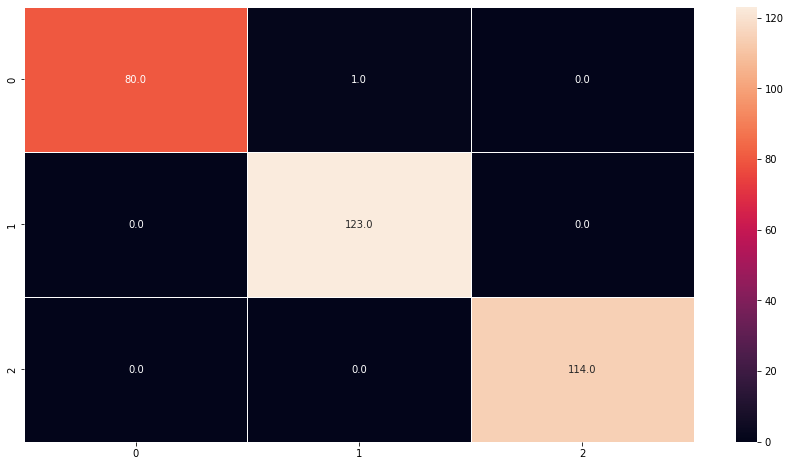

In [344]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
dt = DecisionTreeClassifier(random_state=1024)
dt_grid = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, verbose=True)
dt_grid.fit(x_train, y_train)
pred = dt_grid.predict(x_test)
print('Model Accuracy = ',accuracy_score(y_test,pred))
cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(15,8))
ax = sns.heatmap(cm,annot=True,linewidths=0.5,fmt=".1f")
plt.show()

**XGBCLASSIFIER WITH GRIDSEARCH**

In [347]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True
)
grid_xgb.fit(x_train, y_train)
pred = grid_xgb.predict(x_test)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


Model Accuracy =  0.9968553459119497


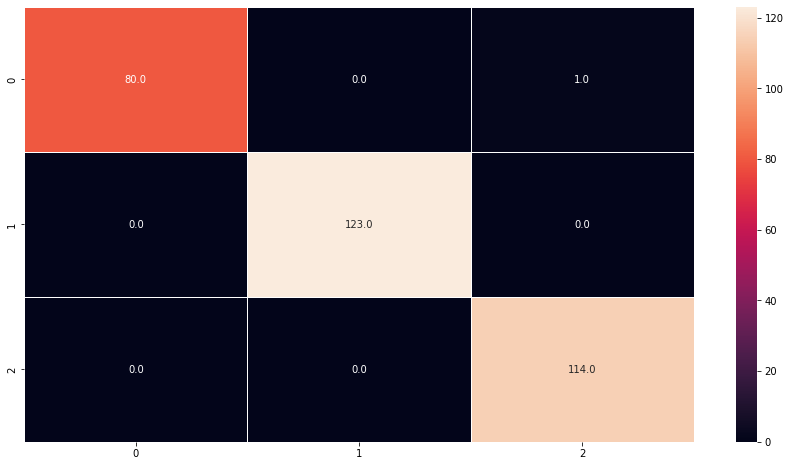

In [348]:
print('Model Accuracy = ',accuracy_score(y_test,pred))
cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(15,8))
ax = sns.heatmap(cm,annot=True,linewidths=0.5,fmt=".1f")
plt.show()